In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

# To Do for Sod Shock Tube:
- Try implementing the simpler flux splitting
- Check that my computation of the transformed values is correct


# DONE for sod shock tube:
- Fix boundary conditions
    - BC’s should be zero in normal velocity, Neumann in slip/tangential velocity
    - Check my boundary conditions so that the energy is a neumann condition
    - Check my boundary conditions so that density is neumann
- Update k values xi_x/J, xi_y/J for F, eta_x/J, eta_y/J for G., use k tilde equation from B4
- Initialize shock tube to zero velocity, should not obtain any divide by zero errors
- Update the initialization to the wikipedia initialization, this is dimensional
    - Use a pressure of 1 Pa, 10 Pa, rather than something reasonable, as this is a fake problem. Do it for validation
- implement actually reasonable time stepping based on Pramod's time step suggestions
    - Shock tube delta t: should be obtained from the maximum of the eigenvalues, not as a fixed dt = 0.4*dx.
    - Multiply time step from eigenvalues by 0.1 or 0.2 for the CFL- implement actually reasonable time stepping based on Pramod's time step suggestions
    - Shock tube delta t: should be obtained from the maximum of the eigenvalues, not as a fixed dt = 0.4*dx.
    - Multiply time step from eigenvalues by 0.1 or 0.2 for the CFL


# To Do for Airfoil Problem
- FOR THE ELLIPSE, WRAP IN A CLOCKWISE ORDER. DON’T KNOW WHY THIS IS IMPORTANT, BUT IT IS APPARENTLY VERY IMPORTANT. OTHERWISE, YOU RUN INTO COMPLEX ERRORS.
- Fix the negative values of rhoE, pressure

# DONE for Airfoil Problem
- Make grid generation function for 4:1 ellipse in x/y and xi/eta space
    - sponge layer, make it more coarse as it goes out (scaling with r) so the elements stay roughly square
    - $x = \cosh(\eta)*\cos(\xi) \to x = \cosh()$
    - 50 chord lengths away in all directions
    - make the mesh finer at the base, so that I can use the same mesh for viscous (target y+ of 1)
- Create initialization of U for the mesh
    - When doing the initialization of U for the elliptical wing, look at the photo Ricardo sent me
- Create function to apply boundary conditions for the problem
- Check that all my indexing is correct, appropriate
- Determine a reasonable time step
- Make plots


# Steps to Do CFD

Step 1: Create mesh

Step 2: Compute mesh metrics

Step 3: Initialize the flow state U in the main domain

Step 4: Initialize ghost cells and boundary conditions

Step 5: Compute dt = CFL\* max stable time step

Step 6: Compute R, an approximation of the time derivative of each value of U at each point (j,i), using steger-warming flux vector splitting to upwind appropriately

Step 7: Compute new value of U in the main domain using explicit time stepping

Step 8: Update boundary conditions/ghost cells

# Define Global Variables

Some variables will be global constants throughout the problem. We define these constants here:

In [1855]:
gamma = 1.4
p_infty = 1/gamma
rho_infty = 1
c_infty = 1 # math.sqrt(gamma*p_infty/r_infty)

# Note that these values are nondimensionalized. 
# If we want to solve a real problem, we can choose some physical values for p and rho infty.

# Sod Shock Tube Problem

# Prep plotting functions!

For the sod shock tube, we want a plot of rho/rho0 vs x.

In [1838]:
def plot2var(x,y,xlabel='x',ylabel='rho/rho_0',filename=[]):
    plt.figure(figsize=(10,5))
    axes_internal = plt.gca()
    axes_internal.set_xlabel(xlabel)
    axes_internal.set_ylabel(ylabel)
    plt.title(ylabel + ' vs ' + xlabel)
    plt.plot(x,y)
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '.png')
    plt.show()
    
    
def PlotJacobian(x,y,J,levels=5,filename=[],printvals=False):
    # xgrid, ygrid = np.meshgrid(x,y)
    # print(xgrid)
    # print(ygrid)
    
    
    # Assuming x, y, J, all have the same shape
    S1, S2 = np.shape(x)
    if filename == 'Sod_Shock_Tube':
        x = x[1:S1-1,1:S2-1]
        y = y[1:S1-1,1:S2-1]
        J = J[1:S1-1,1:S2-1]
    elif filename == 'Elliptical_Wing':
        J[:,S2-1] = J[:,1] # wrap J in xi, where the coordinates are (eta row, xi column)
        x = x[1:S1-1,1:S2]
        y = y[1:S1-1,1:S2]
        J = J[1:S1-1,1:S2]
    
    if printvals:
        print(x)
        print(y)
        # print(J)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x,y,J)
    plt.xlabel('x')
    plt.ylabel('y')
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '_MeshScatter.png')
    plt.show()
    
    plt.figure()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(x,y,J) #light blue
    plt.title('Jacobian 3D Plot ' + filename)
    plt.xlabel('x')
    plt.ylabel('y')
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '_Jacobian3D.png')
    plt.show()
    
    plt.figure()
    cp = plt.contourf(x, y, J, levels)#, colors='black', linestyles='dashed')
    # plt.clabel(cp, inline=True, fontsize=10)
    plt.title('Jacobian Contour: ' + filename)
    plt.xlabel('x')
    plt.ylabel('y')
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '_JacobianContour.png')
    plt.show()
    
    return None


def plotU(xvals,yvals,Uinitial,index,levels=5,save=False,filename=[]):
    if index == 0:
        plotname = 'rho'
        plotvar = Uinitial[:,:,0]
        
    elif index == 1:
        plotname = 'u'
        plotvar = Uinitial[:,:,1]/Uinitial[:,:,0]
    elif index == 2:
        plotname = 'v'
        plotvar = Uinitial[:,:,2]/Uinitial[:,:,0]
    elif index == 3:
        plotname = 'e'
        plotvar = Uinitial[:,:,3]/Uinitial[:,:,0]
    elif index == 4:
        plotname = 'P'
        plotvar = (gamma-1)/Uinitial[:,:,0]*(Uinitial[:,:,3] - 1/2*(Uinitial[:,:,1]**2 + Uinitial[:,:,2]**2))
    
    S1, S2 = np.shape(xvals)
    plotvar[:,S2-1] = plotvar[:,1] # wrap variable of interest in xi to plot contour of periodic fxns
    # Note that the coordinates are (eta row, xi column)
    # Eliminate all ghost cells except 1 periodic ghost cell in xi (ASSUME 1 GHOST CELL ON EACH SIDE)
    xvals = xvals[1:S1-1,1:S2]
    yvals = yvals[1:S1-1,1:S2]
    plotvar = plotvar[1:S1-1,1:S2]
    
    plt.figure()
    cp = plt.contourf(xvals, yvals, plotvar, levels)#, colors='black', linestyles='dashed')
    # plt.clabel(cp, inline=True, fontsize=10)
    plt.title('Contours of ' + plotname + ', ' + filename)
    plt.xlabel('x')
    plt.ylabel('y')
    if save:
        plt.savefig('FinalProject_' + filename + '_' + plotname + '.png')
    plt.show()
    
    plt.figure()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(xvals,yvals,plotvar) #light blue
    plt.title(' 3D Plot of ' + plotname + ', '+ filename)
    plt.xlabel('x')
    plt.ylabel('y')
    if len(filename) != 0:
        plt.savefig('FinalProject_' + filename + '_Jacobian3D.png')
    plt.show()
    
    return None

# Compute Mesh Metrics

Given any 2D mesh, we want to be able to compute the mesh metrics. We can numerically compute the derivatives of $x$ and $y$ with respect to $\xi$ and $\eta$:

$$x_\xi = \frac{x_{i+1}-x_{i-1}}{\xi_{i+1}-\xi_{i-1}}$$

We can write the transformation of derivatives in $x$, $y$ to $\xi$, $\eta$ as follows:

$$\begin{pmatrix}
\frac{\partial}{\partial \xi}\\
\frac{\partial}{\partial \eta}
\end{pmatrix} = \begin{pmatrix}
x_\xi & y_\xi\\
x_\eta & y_\eta
\end{pmatrix}\begin{pmatrix}
\frac{\partial}{\partial x}\\
\frac{\partial}{\partial y}
\end{pmatrix}
$$

We define:

$$T = \begin{pmatrix}
x_\xi & x_\eta\\
y_\xi & y_\eta
\end{pmatrix}$$

Thus, we have:

$$T^{-1} = \begin{pmatrix}
\xi_x & \xi_y\\
\eta_x & \eta_y
\end{pmatrix}$$

By performing the matrix inversion from the definition of $T$, we have:
$$T^{-1} = J \begin{pmatrix} 
y_\eta & -x_\eta \\
- y_\xi & x_\xi
\end{pmatrix} = \begin{pmatrix}
\xi_x & \xi_y \\
\eta_x & \eta_y
\end{pmatrix}$$

In [1765]:
def meshmetrics(numxint,numyint,numghosts,coords):
    Ni = numxint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numyint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    
    # COMPUTING MESH METRICS
    
    # unpack x, y, xi, eta, from gridcoords
    x = coords[:,:,0]
    y = coords[:,:,1]
    xi = coords[:,:,2]
    eta = coords[:,:,3]
    
    # Initialize derivatives of x,y
    # This could be a separate function meshmetric(x,y,xi,eta)
    dxdxi = np.zeros((Nj,Ni)) # size based on number of xi values (91)
    dxdeta = np.zeros((Nj,Ni)) # size based on the number of eta values (2)
    dydxi = np.zeros((Nj,Ni))
    dydeta = np.zeros((Nj,Ni))
    # Initialize J
    J = np.zeros((Nj,Ni))
    # Initialize derivatives of xi,eta
    dxidx = np.zeros((Nj,Ni))
    detadx = np.zeros((Nj,Ni))
    dxidy = np.zeros((Nj,Ni))
    detady = np.zeros((Nj,Ni))
    for i in range(1,numxint+1): 
        for j in range(1,numyint+1):
            # derivatives of x,y wrt xi,eta
            dxdxi[j,i] = (x[j,i+1] - x[j,i-1])/(xi[j,i+1]-xi[j,i-1]) # 0.05
            dxdeta[j,i] = (x[j+1,i] - x[j-1,i])/(eta[j+1,i]-eta[j-1,i]) # 0
            dydxi[j,i] = (y[j,i+1] - y[j,i-1])/(xi[j,i+1]-xi[j,i-1]) # 0
            dydeta[j,i] = (y[j+1,i] - y[j-1,i])/(eta[j+1,i]-eta[j-1,i]) # 1
            # print('------')
            # print(y[j+1,i])
            # print(y[j-1,i])
            # print(eta[j+1,i])
            # print(eta[j-1,i])
            #Jacobian of transformation, J
            J[j,i] = 1/(dxdxi[j,i]*dydeta[j,i]-dxdeta[j,i]*dydxi[j,i])
            #derivatives of xi,eta wrt x,y (comes from inverting the transformation matrix)
            dxidx[j,i] = J[j,i] * dydeta[j,i]
            dxidy[j,i] = -J[j,i] * dxdeta[j,i]
            detadx[j,i] = -J[j,i] * dydxi[j,i]
            detady[j,i] = J[j,i] * dxdxi[j,i]
    coords[:,:,4] = dxidx
    coords[:,:,5] = detadx
    coords[:,:,6] = dxidy
    coords[:,:,7] = detady
    coords[:,:,8] = J
    # Note that the derivatives of xi, eta wrt x,y are nan in the edges. 
    
    return coords

# Create meshes in x, y, $\xi$, $\eta$

This should be a function, so that I can choose what mesh to read into my solver -- a sod shock tube mesh, or a 4:1 elliptical airfoil mesh, or a NACA mesh!

Make sure that my $\Delta\xi$ and $\Delta\eta$ values between points is always 1!!!!

Be very, very careful if I change the number of ghosts on one side only -- this will make it so that my indexing will change in the flux computation, and also my x and y values will not have that point either before or after...

Would probably be better programming practice to fully pull the function call to meshmetrics out of this mesh creation function, but I've already written the rest of the program assuming all the grid info and mesh metrics are packaged together, so I'll put a meshmetrics function call inside of each grid generation function.

dx = 0.1111111111111111
dy = 1.0
[[-0.11111111  0.          0.11111111  0.22222222  0.33333333  0.44444444
   0.55555556  0.66666667  0.77777778  0.88888889  1.          1.11111111]
 [-0.11111111  0.          0.11111111  0.22222222  0.33333333  0.44444444
   0.55555556  0.66666667  0.77777778  0.88888889  1.          1.11111111]
 [-0.11111111  0.          0.11111111  0.22222222  0.33333333  0.44444444
   0.55555556  0.66666667  0.77777778  0.88888889  1.          1.11111111]
 [-0.11111111  0.          0.11111111  0.22222222  0.33333333  0.44444444
   0.55555556  0.66666667  0.77777778  0.88888889  1.          1.11111111]]
[[ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]]
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 0.  1.  2

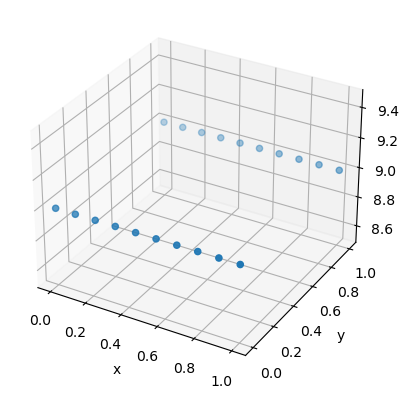

<Figure size 640x480 with 0 Axes>

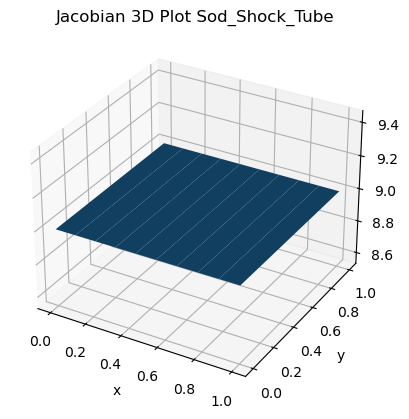

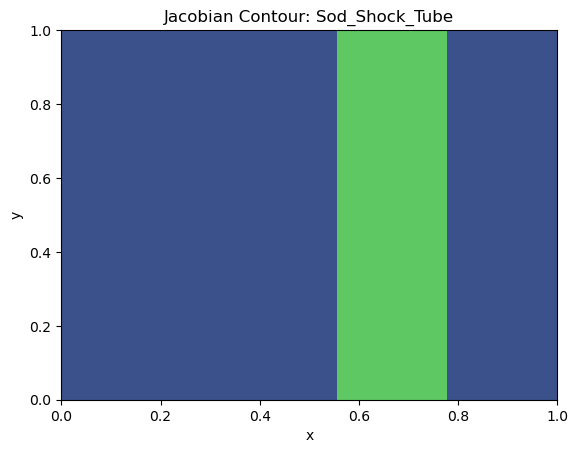

In [1766]:
def regxygrid(numxint,numyint,numghosts, L, H):
    # numxint is the number of internal points in i. Number of intervals is numpts-1.
    # numyint is the number of internal points in j. Number of intervals is numpts-1.
    
    # This calculation is copied in main() rather than passing more info to the function
    # Probably a bad design decision, make these inputs to the function
    # total number of points in each direction
    Ni = numxint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numyint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    
    dx = L/(numxint-1) # num cells = numpoints-1
    dy = H/(numyint-1) # because this problem is 1D, this is somewhat arbitrary. Set dy = 1.
    print('dx = ' + str(dx))
    print('dy = ' + str(dy))
    
    
    xi = np.zeros((Nj,Ni))
    eta = np.zeros((Nj,Ni))
    for i in range(Ni):
        for j in range(Nj):
            xi[j,i] = i
            eta[j,i] = Nj-j-1
    # The reason I use two for loops instead of np.arange 
    # is that I don't want to write a for loop to copy one vector many times, since xi and eta are the same.
    # This is inefficient storage-wise, but it works nicely to make all the data have the same 2D format.

    x = (xi-numghosts)*dx # for this particular mesh, where x=xi (but then subtract the ghosts)
    y = (eta-numghosts)*dy # y=eta (but subtract the ghosts)

    
    # print(xi)
    # print(eta)
    # print(x)
    # print(y)
    
    coords = np.zeros((Nj,Ni,9)) # Nj rows, Ni columns, 9 layers
    coords[:] = np.nan
    # coords[:] = 27
    # Note that any value that is not filled will default to zero. 
    # This can be dangerous, so I fill all the unused values with NaN's
    
    # coords[0:Nj,0:Ni,0] = x
    coords[:,:,0] = x 
    coords[:,:,1] = y
    coords[:,:,2] = xi
    coords[:,:,3] = eta
    # Note that this includes values of coordinates for the ghost cells
    
    coords = meshmetrics(numxint,numyint,numghosts,coords) #note that the slice indexing excludes the last value

    # coords contains an array for each of x, y, xi, and eta, and derivatives of xi and eta. 
    # Each specific value can be accessed by indices i,j.
    # For x, coords[j,i,0]=xval, coords[j,i,1] = yval, coords[j,i,2]=xival, coords[j,i,3]=etaval.
    # coords[j,i,4] = dxidx, coords[j,i,5] = detadx, coords[j,i,6] = dxidy, coords[j,i,7] = detady, coords[j,i,8] = J
    return coords

sodshockgrid = regxygrid(numxint=10,numyint=2,numghosts=1,L=1,H=1)
# For sod shock tube, L = 4.5. H = 1 for arbitrary convenience, dx = 1.0
# Note that x=1.95 is the boundary between points. Potentially want to make it so no points lie there?
# x=1.95 is halfway between points? 

# sodshockgrid(j, i, quantity index)
x = sodshockgrid[:,:,0]
print(x) # x
y = sodshockgrid[:,:,1]
print(y) # y
print(sodshockgrid[:,:,2]) # xi
print(sodshockgrid[:,:,3]) # eta
print(sodshockgrid[:,:,4]) # dxidx
print(sodshockgrid[:,:,5]) # detadx
print(sodshockgrid[:,:,6]) # dxidy
print(sodshockgrid[:,:,7]) # detady
J = sodshockgrid[:,:,8]
print(J) # J

print('--------------------')

PlotJacobian(x,y,J,levels=1,filename = 'Sod_Shock_Tube')

# Explicit Euler Time Stepping

$$U_{i,j}^{n+1} = U_{i,j}^n - \Delta t * J_{i,j}*R_{i,j}$$

Note that $U_{i,j}$ is a 1D array at each point in space, and so the full $U$ throughout the 2D domain at time $t$ is a 3D array. Similarly, $R_{i,j}$ is a 1D array at each point in space, and so the full $R$ throughout the 2D domain at time $t$ is a 3D array.

Computing $U_{i,j}^{n+1}$ requires us to initialize $U_{i,j}^n$, pick a stable time step $\Delta t$, compute the jacobian of our mesh transformation $J$, and the quantity $R$, which in turn requires us to obtain the spatial derivatives of $\tilde{F}$ and $\tilde{G}$ using upwinding and flux vector splitting.

One question: Where does the upwinding come into play? We can compute $F^+$ and $F^-$ if we really want to, but where does this come in?

Answer: This comes into play when we compute the spatial derivative. We upwind with $F^-$ and downwind with $F^+$ (if i recall correctly).

In [1767]:
def expeuler(u,dt,J,R,Ni,Nj,numghosts):
    uk1 = np.full_like(u,0)
    for i in range(numghosts,Ni-numghosts):
        for j in range(numghosts,Nj-numghosts):
            uk1[j,i,:] = u[j,i,:] - dt*J[j,i]*R[j,i,:]
    return uk1

# Computing Fluxes

In order to compute the derivatives of $\tilde{F}$ and $\tilde{G}$, we need to compute the derivatives $A$ and $B$ with respect to $U$:

$$\frac{\partial U}{\partial t} + \frac{\partial F}{\partial \xi} + \frac
{\partial G}{\partial \eta}=0$$
$$\frac{\partial U}{\partial t} + \frac{\partial F}{\partial U}\frac{\partial U}{\partial \xi} + \frac
{\partial G}{\partial U}\frac{\partial U}{\partial \eta}=0$$
$$\frac{\partial U}{\partial t} + A \frac{\partial U}{\partial \xi} + B \frac{\partial U}{\partial \eta}=0$$

Note that:
$$F = AU$$




Then, if we assume $A$ is constant in space, $\frac{\partial F}{\partial \xi} =A  \frac{\partial U}{\partial \xi}$. Otherwise, $\frac{\partial F}{\partial \xi} =A  \frac{\partial U}{\partial \xi} + \frac{\partial A}{\partial \xi}U$. 

To start, let's compute $A$ and $B$:


HOLD UP:
We actually don't need to compute these, because Steger and Warming have already done it for us. They also took these matrices, found the eigenvector/eigenvalue decomposition, split the eigenvalues into the + and - components, and multiplied the right eigenvector matrix by the eigenvalue+/- matrices and the left eigenvector matrix, and computed the generalized flux vector. This result is what we will compute, for the sake of me saving time right now. Later, I can come back and determine A and B, and then the eigendecompositions, and then perform the matrix multiplication $Q*lambda*Qinv*U$, and then obtain the generalized flux vector that Steger and Warming obtained.


In order to compute these derivatives in a compressible flow where there may be some shockwaves, we should upwind appropriately. To do this, we use Steger and Warming's flux vector splitting method, in particular, see equation B9 in their paper.


We also use k1 and k2 as the derivatives of xi and eta wrt x and y, divided by J. We use xi derivatives for F and eta diervatives for G. This is because equation B1 is analogous to the equation in the assignment for Ftilde and Gtilde.

In [1848]:
def fluxpm(fg,plusminus,U,xi_x,xi_y,eta_x,eta_y,J,smoothing=True): # Take in the xi, eta derivatives as well
    # Note that here, U is a vector for the particular i,j that we are computing fluxes at
    if fg == 'F':
        k1 = xi_x/J
        k2 = xi_y/J
    elif fg == 'G':
        k1 = eta_x/J
        k2 = eta_y/J
        
    # These equations B4 in Steger and Warming are required for k1 and k2 not equal to 0,1 or 1,0. 
    # However, for my rectangular grid with dy = 1, these will be 1,0 
    k1t = k1/(k1**2+k2**2)**(1/2)
    k2t = k2/(k1**2+k2**2)**(1/2)
    # print('-----')
    # print(k1t)
    # print(k2t)
    
    rho = U[0] # rho
    u = U[1]/U[0] # rho*u/rho = u
    v = U[2]/U[0] # rho*v/rho = v
    p = (gamma-1)*(U[3] - rho*(u**2+v**2)/2)
    c = math.sqrt(gamma*p/rho)
    # Note that gamma is a global variable, but c is a local variable
    
    # this is somewhat wasteful in terms of computations.
    # the generalized flux vector requires more computations than the flux vector 
    # for each individual F/G would require. However, this is easier to implement.
    # It also means I don't have to define as many functions.
    l1 = k1t*u + k2t*v 
    l3 = l1 + c*(k1t**2+k2t**2)**(1/2) # Note that this is equal to l1+c for all values of interest
    l4 = l1 - c*(k1t**2+k2t**2)**(1/2) # Note that this is equal to l1-c for all values of interest
    
    # The "smoothing"
    if smoothing:
        l1 = smoothlambda(l1,plusminus)
        l3 = smoothlambda(l3,plusminus)
        l4 = smoothlambda(l4,plusminus)
    else:
        l1 = roughlambda(l1,plusminus)
        l3 = roughlambda(l3,plusminus)
        l4 = roughlambda(l4,plusminus)
    
    fluxvec = np.zeros((4,1)) # 4 rows, 1 column
    
    fluxvec[0] = 2*(gamma-1)*l1+l3+l4
    fluxvec[1] = 2*(gamma-1)*l1*u + l3*(u+c*k1t) + l4*(u-c*k1t)
    fluxvec[2] = 2*(gamma-1)*l1*v + l3*(v+c*k2t) + l4*(v-c*k2t)
    fluxvec[3] = (gamma-1)*l1*(u**2+v**2) + l3/2*((u+c*k1t)**2 + (v+c*k2t)**2) + \
    l4/2*((u-c*k1t)**2 + (v-c*k2t)**2) + (3-gamma)*(l3+l4)*c**2/(2*(gamma-1))
    fluxvec = rho/(2*gamma) * fluxvec
    return fluxvec
    
        
    
def smoothlambda(lambdaval,plusminus=[]):
    ep = 0.01 # not sure if this is a good value... should try some different ones?
    if plusminus == 'plus':
        lpm = (lambdaval + math.sqrt(lambdaval**2+ep**2))/2
    elif plusminus == 'minus':
        lpm = (lambdaval - math.sqrt(lambdaval**2+ep**2))/2
    return lpm

def roughlambda(lambdaval,plusminus=[]):
    if plusminus == 'plus':
        lpm = (lambdaval + abs(lambdaval))/2
    elif plusminus == 'minus':
        lpm = (lambdaval - abs(lambdaval))/2
    return lpm

# Flux Derivatives


We have from Pramod's slides "evec" that the formulation of explicit Euler we are to use is given with the following definition of a quantity $R$:

$$R_{i,j} = \left(\frac{\partial\tilde{F}}{\partial\xi} + \frac{\partial\tilde{G}}{\partial\eta}\right)_{i,j}$$



Recall from the assignment that we can implement upwinding as follows for Steger and Warming's flux splitting method:

$$\frac{\partial \tilde{F}}{\partial \xi} \approx \frac{\tilde{F}_i^+ - \tilde{F}_{i-1}^+}{\Delta \xi} + \frac{\tilde{F}_{i+1}^- - \tilde{F}_{i}^-}{\Delta \xi} $$

$$\frac{\partial \tilde{G}}{\partial \eta} \approx \frac{\tilde{G}_i^+ - \tilde{G}_{i-1}^+}{\Delta \eta} + \frac{\tilde{G}_{i+1}^- - \tilde{G}_{i}^-}{\Delta \xi} $$

In order to get the $\tilde{F}$ and $\tilde{G}$ values, we have to apply the following computations:

$$\tilde{F}^+ = \frac{\xi_x}{J}F^+ + \frac{\xi_y}{J}G^+$$
$$\tilde{F}^- = \frac{\xi_x}{J}F^- + \frac{\xi_y}{J}G^-$$
$$\tilde{G}^+ = \frac{\eta_x}{J}F^+ + \frac{\eta_y}{J}G^+$$
$$\tilde{G}^- = \frac{\eta_x}{J}F^- + \frac{\eta_y}{J}G^-$$




$$R_{i,j} = \left(\frac{\partial\tilde{F}}{\partial x} + \frac{\partial\tilde{G}}{\partial y}\right)_{i,j}$$





In [1849]:
def getR(U,numghosts,sodshockgrid,Ni,Nj): 
    # THIS SHOULD include the xi, eta derivatives evaluated as a function of space.
    # Perhaps they should be evaluated inside the i, j for loop
    # Try: create a function that gets derivative of xi, eta wrt x,y
    # inputs (x,y) grid and (xi,eta) grid
    # Evaluate inside this loop
    
    
    dGdeta = np.full_like(U,0)
    dFdxi = np.full_like(U,0)
    Rmatr = np.full_like(U,0)
    for i in range(numghosts,Ni-numghosts): # NEED TO EXCLUDE THE GHOST CELLS
        # print('i = ' + str(i))
        for j in range(numghosts,Nj-numghosts): # NEED TO EXCLUDE THE GHOST CELLS
            # print('j = ' + str(j))
            # obtain xi, eta derivatives here instead of making them globals
            # These will be identically equal for most values in the regular sod shock grid, but
            # not for the curvilinear grid.
            xi_x = sodshockgrid[j,i,4]
            xi_y = sodshockgrid[j,i,6]
            eta_x = sodshockgrid[j,i,5]
            eta_y = sodshockgrid[j,i,7]
            J = sodshockgrid[j,i,8]
            
            # MAKE FLUX CALCULATIONS TAKE IN XI, ETA DERIVATIVE VALUES AS WELL
            
            # F values
            Fpl = fluxpm('F','plus',U[j,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True)
            Flopl = fluxpm('F','plus',U[j,i-1],xi_x,xi_y,eta_x,eta_y,J,smoothing=True) #F_{i-1}^+ (lo plus)
            Fhimi = fluxpm('F','minus',U[j,i+1],xi_x,xi_y,eta_x,eta_y,J,smoothing=True) #F_{i+1}^- (hi minus)
            Fmi = fluxpm('F','minus',U[j,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True)
            
            # G values
            Gpl = fluxpm('G','plus',U[j,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True)
            Glopl = fluxpm('G','plus',U[j-1,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True) #G_{j-1}^+ (lo plus)
            Ghimi = fluxpm('G','minus',U[j+1,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True) #G_{j+1}^- (hi minus)
            Gmi = fluxpm('G','minus',U[j,i],xi_x,xi_y,eta_x,eta_y,J,smoothing=True)
            
            # Tilde F values
            tFpl = xi_x/J*Fpl + xi_y/J*Gpl
            tFlopl = xi_x/J*Flopl + xi_y/J*Glopl
            tFhimi = xi_x/J*Fhimi + xi_y/J*Ghimi
            tFmi = xi_x/J*Fmi + xi_y/J*Gmi
            
            # Tilde G values
            tGpl = eta_x/J*Fpl + eta_y/J*Gpl
            tGlopl = eta_x/J*Flopl + eta_y/J*Glopl
            tGhimi = eta_x/J*Fhimi + eta_y/J*Ghimi
            tGmi = eta_x/J*Fmi + eta_y/J*Gmi
            
            # Compute derivatives
            dFdxicol = (tFpl - tFlopl) + (tFhimi - tFmi) # d tilde F d xi
            dFdxivec = np.reshape(dFdxicol,(-1))
            dFdxi[j,i,:] = dFdxivec
            dGdetacol = (tGpl - tGlopl) + (tGhimi - tGmi) # d tilde G d eta
            dGdetavec = np.reshape(dGdetacol,(-1))
            dGdeta[j,i,:] = dGdetavec
            # NOTE THAT I ASSUME DELTA ETA AND DELTA XI BOTH EQUAL 1
            # print('----------')
            # print(tFpl-tFlopl)
            # print('--')
            # print(tFhimi-tFmi)
    # Compute R
    R = dFdxi + dGdeta
    # R should be non-zero where ever there are gradients of U.
    return R

# NEED TO TEST THAT THIS DOES NOT FILL GHOST CELLS FOR R.
# This will result in an out of bounds error (since there are no i-1 and/or i+1 points next to ghost cells)

# Initialize Solution

Note that pleft = 1 Pa, pright = 0.1 Pa. u and v are initialized to 0. Rho is initialized to 1 and 0.125.

Recall that:
$$\rho E =  \rho \frac{(u^2 + v^2 )}{2} + \frac{p}{\gamma-1}$$

Because the velocities are zero to start, this means that if $\gamma=1.4$, $\rho E$ left is $\frac{1}{0.4}=2.5$, and $\rho E$ right is $\rho_r*\frac{0.1}{0.4}=0.25$

<!-- We'll try rho as 3 kg/m$^3$, roughly 3x the 1.225 that is standard for air, to get the high density behavior. -->


In [1850]:
def sodinitial(gridinfo,numxint,numyint,numghosts):
    xvals = gridinfo[:,:,0]
    Ni = numxint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numyint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    # 4 quantities per point (i,j)
    # 0 is rho
    # 1 is rho*u
    # 2 is rho*v
    # 3 is rho*E = rho*P/(gamma-1) + rho^2*q, where q=(u^2+v^2)/2
    Uinitial = np.zeros((numyint+2*numghosts,numxint+2*numghosts,4))
    Uinitial[:,:,:] = np.nan
    for i in range(1,numxint+1): # +1 because range excludes final point
        for j in range(1,numyint+1): # +1 because range excludes final point
            if xvals[j,i] <= 0.5:
                # Uinitial[j,i] = np.array([10, 0, 0, 10**6])
                Uinitial[j,i,:] = np.array([1, 0, 0, 2.5])
            else:
                # Uinitial[j,i] = np.array([10, 0, 0, 10**7])
                Uinitial[j,i,:] = np.array([0.125, 0, 0, 0.25]) 
    # plot(rho/rho0 vs x)
    # print(xvals[1,1:Ni])
    # print(Uinitial[1,1:Ni-1,0])
    plot2var(xvals[1,1:Ni],Uinitial[1,1:Ni,0]) # Uinitial[interior,0], divided by rho0=1 for the higher density value
    # plot2var(xvals[1,1:Ni],Uinitial[1,1:Ni,3]*0.3,xlabel='x',ylabel='pressure')
    return Uinitial

# Apply Boundary Conditions

In [1851]:
def FillSodShockBCs(U,Ni,Nj,printvals=False):
    if printvals:
        print('------')
        print('input of Fill BCs')
        print(U[:,:,1])
    
    # Could maybe do this more efficiently by doing row 1 and row 2 for u and v together using slicing? U[:,0,1:3] = p
    # To revert to original all neumann BC, just set the third index to a : and use only one assignment
    
    # 1st column, x=-dx
    U[:,0,0] = U[:,1,0]
    U[:,0,1] = 0
    U[:,0,2] = U[:,1,2] # should allow v for the left and right BCs for slip walls (inviscid).
    U[:,0,3] = U[:,1,3]
    
    
    # last column, x = L + dx
    U[:,Ni-1,0] = U[:,Ni-2,0]
    U[:,Ni-1,1] = 0
    U[:,Ni-1,2] = U[:,Ni-2,2]# should allow v for the left and right BCs for slip walls (inviscid).
    U[:,Ni-1,3] = U[:,Ni-2,3]
    
    
    # top row, y=H+dy
    U[0,:,0] = U[1,:,0]
    U[0,:,1] = U[1,:,1] # should allow u for the top and bottom BCs for slip walls (inviscid).
    U[0,:,2] = 0
    U[0,:,3] = U[1,:,3]
    
    # bottom row, y = -dy
    U[Nj-1,:,0] = U[Nj-2,:,0] 
    U[Nj-1,:,1] = U[Nj-2,:,1]  # Should allow u for the top and bottom BCs for slip walls (inviscid).
    U[Nj-1,:,2] = 0
    U[Nj-1,:,3] = U[Nj-2,:,3] 
    
    
    # BC's should be neumann in energy and density, but dirchlet (zero) in velocity.
    # What is the substantive meaning of neumann in energy boundary condition? Neumann pressure makes sense, but Neumann energy is confusing...
    # This means that no energy flows in or out of the point in the direction toward the boundary, makes more sense from a conservation of energy perspective
    
    # 0 and 3 should be Neumann
    # 1 and 2 should be zero
    
    if printvals:
        print('Result of Fill BCs')
        print(U[:,:,1])
        print('------')
    # SHOULD CHECK THAT TOP AND BOTTOM ROWS HAVE THE APPROPRIATE YVALUES
    return U

# Compute the appropriate time step

We compute the maximum allowable explicit time step at each time, and then multiply by a CFL number of 0.1 to obtain a good, stable value with good resolution. 

Note that when calculating the pressure, we apply the following formula from Pramod's slides:



$$p = (\gamma-1)\left[ \rho E - \rho\frac{u^2+v^2}{2}\right]$$
$$p = (\gamma-1)\left[ \rho E - \frac{1}{2}\left(\frac{m^2}{\rho} + \frac{n^2}{\rho}\right)\right]$$

where $m=\rho u$, and $n=\rho v$

In [1852]:
def getdt(U,grid,numxint,numyint,CFL):
    
    potential_dtvals = np.zeros([numyint,numxint,2]) 
    # This 3D array of dt values is the size of the interior points.
    # Indices will be i-1, j-1
    
    for i in range(1,numxint+1): # indices of interior points
        for j in range(1,numyint+1):
            # Copy these computations over so that I don't have to add another big numpy array to pack and unpack between functions
            rho = U[j,i,0] # rho
            u = U[j,i,1]/U[j,i,0] # rho*u/rho = u
            v = U[j,i,2]/U[j,i,0] # rho*v/rho = v
            e = U[j,i,3]/U[j,i,0] # rho*e/rho = e
            p = (gamma-1)*(rho*e - rho/2*(u**2 + v**2))
            
            c = math.sqrt(gamma*p/rho)
            
            
            xi_x = grid[j,i,4]
            xi_y = grid[j,i,6]
            eta_x = grid[j,i,5]
            eta_y = grid[j,i,7]
            # print('xi_x = ' + str(xi_x))
            # print('xi_y = ' + str(xi_y))
            # print('eta_x = ' + str(eta_x))
            # print('eta_y = ' + str(eta_y))
            # print('c = ' + str(c))
            # print('u = ' + str(u))
            # print('v = ' + str(v))
            
            
            lmi = abs(xi_x*u + xi_y*v) + c*math.sqrt(xi_x**2 + xi_y**2)
            lmj = abs(eta_x*u + eta_y*v) + c*math.sqrt(eta_x**2 + eta_y**2)
            # print('-------')
            # print('lmi = ' + str(lmi))
            # print('lmj = ' + str(lmj))
            # Why are there so many nan values???
            
            # NOTE THAT I ASSUME DELTA XI, DELTA ETA = 1
            potential_dtvals[j-1,i-1,0] = 1/lmi
            potential_dtvals[j-1,i-1,1] = 1/lmj
    # print(potential_dtvals)
    dt = CFL * np.amin(potential_dtvals)
    return dt

# Perform Time Stepping

This is where we perform the actual solution of the problem! Also, make sure to pick a reasonable time step!

In [1853]:
def sodshockmain():
    
    # Sod shock tube grid parameters. 
    # All of these are copied inside the regxygrid function.... should probably avoid duplication
    numxint = 200 # To match figure 1 of steger and warming better, use ~45 points for the interior domain (184 time steps)
    numyint = 2
    numghosts = 1
    L = 1 # 4.5 for steger/warming, 1 for wikipedia
    H = 1
    dx = L/(numxint-1) # num cells = numpoints-1
    dy = H/(numyint-1) # because this problem is 1D, this is somewhat arbitrary. Set dy = 1
    
    Ni = numxint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numyint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides


    # Determine runtime
    stoptime = 0.2
    t0 = 0
    t = t0
    tstep = 0
    CFL = 0.1
    
    
    # Create grid and compute mesh metrics
    # xvalues 0, yvalues 1, xi values 2, eta values 3, 
    # dxidx 4, detadx 5, dxidy 6, detady 7, J 8
    sodshockgrid = regxygrid(numxint,numyint,numghosts,L,H)
    J = sodshockgrid[:,:,8]
    
    # Initialize solution and derivatives
    U = sodinitial(sodshockgrid,numxint,numyint,numghosts)
    U = FillSodShockBCs(U,Ni,Nj)
    
    # print('initial condition' )
    # print('u')
    # print(str(U[:,:,1]/U[:,:,0]))
    # print('rho*E')
    # print(str(U[:,:,3]))
    
    
    # Iterate throughout time
    while t <= stoptime:
        R = getR(U,numghosts,sodshockgrid,Ni,Nj)
        
        dt = getdt(U,sodshockgrid,numxint,numyint,CFL)
        tstep += 1
        t += dt
        print('for timestep = ' + str (tstep) + ' at t = ' + str(t) + ', dt = ' + str(dt))
        
        U = expeuler(U,dt,J,R,Ni,Nj,numghosts)
        U = FillSodShockBCs(U,Ni,Nj)
        
        
        
        # print('R')
        # print(R[:,:,3])
        # print('rho/rho0')
        # print(str(U[:,:,0]))
        # print('u')
        # print(str(U[:,:,1]/U[:,:,0]))
        # print('rho*E')
        # print(str(U[1,:,3]))
    
    print('Completed after ' + str(tstep) + ' time steps')
    xvals = sodshockgrid[1,numghosts:Ni-numghosts,0]
    plot2var(xvals,U[1,numghosts:Ni-numghosts,0],filename='SodShockTube')
    return U

dx = 0.005025125628140704
dy = 1.0


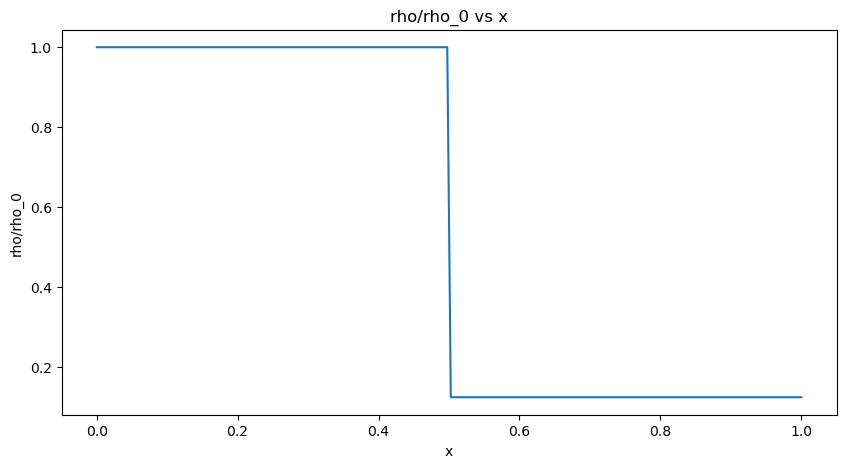

for timestep = 1 at t = 0.0004247006305168397, dt = 0.0004247006305168397
for timestep = 2 at t = 0.0007901489210202058, dt = 0.0003654482905033661
for timestep = 3 at t = 0.0011187073554081747, dt = 0.00032855843438796885
for timestep = 4 at t = 0.0014289624634623934, dt = 0.0003102551080542187
for timestep = 5 at t = 0.0017282120811946055, dt = 0.0002992496177322121
for timestep = 6 at t = 0.002020191773241722, dt = 0.00029197969204711654
for timestep = 7 at t = 0.0023070937995751197, dt = 0.00028690202633339777
for timestep = 8 at t = 0.002590318769273603, dt = 0.00028322496969848345
for timestep = 9 at t = 0.002870815168079166, dt = 0.00028049639880556326
for timestep = 10 at t = 0.003149253163474049, dt = 0.0002784379953948826
for timestep = 11 at t = 0.003426121793726572, dt = 0.00027686863025252323
for timestep = 12 at t = 0.0037017870213745217, dt = 0.00027566522764794967
for timestep = 13 at t = 0.003976528237830202, dt = 0.00027474121645567994
for timestep = 14 at t = 0.00425

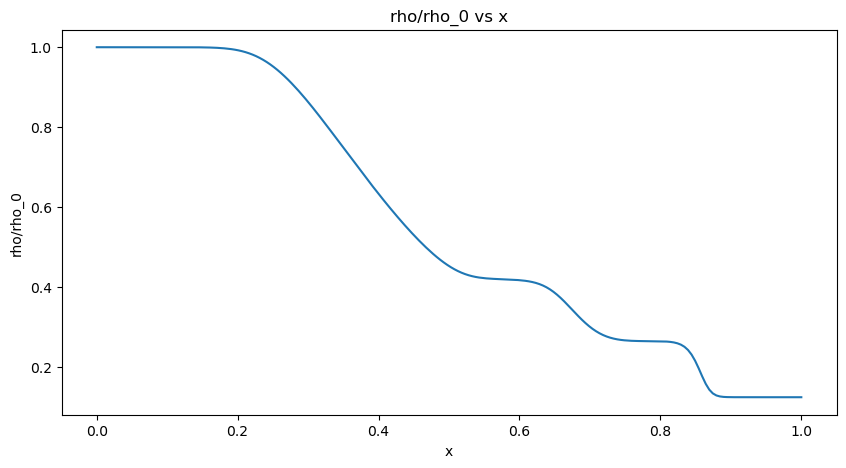

In [1854]:
Ufinal = sodshockmain()
# Initial condition is good
# After 1 time step, the first ghost cells are all NaN's. 
# After adding U = FillSodShockBCs(U,Ni,Nj), the next time step, it becomes 1's except at the boundary
# Density becomes zero at the boundary, and then the first two columns become NaN except for those zero values.
# What is filling those zero values in the last two columns? Even without filling the BC's, these are becoming zero.
# What is filling the zero values in the bottom row? Even without the BC filling, these become zero.

# After some investigation, I have found that R is zero at all points, which is not good.
# Something is wrong with the flux vector splitting, particularly in the pressure/energy term
# pressure/energy is the only one that should be different and have a non-zero R at the pressure discontinuity.

# However, even though R is zero, somehow the last two columns of U are becoming zero.
# Additionally, the bottom two rows are also becoming zero.

# To diagnose this error, let's try a much sparser grid: 2x2 interior.

# After defining c = sqrt(gamma*P/rho), we no longer get NaN values. However, the density does become negative.
# This is clearly incorrect, and something else is clearly wrong with the flux splitting.
# I should try the simpler flux splitting, just to make sure that everything else is working properly.

# Here, the result is valid, but the shape is wrong. I think the wave needs to propagate faster.
# Need to check that my flux splitting is correct, and double check my explicit euler.

# Now I get a maximum stable explicit time step of 135, which is clearly wrong. lmi should be larger than 0.075 -- 

# Elliptical Airfoil Problem

Most of the machinery we built for the sod shock tube will be valid. However, we will need to remake:
- mesh generation function for ellipse, with clustering near wall for lower y+
- break out mesh metrics calculation function and mesh generation function for general use, swappability
- Understand nondimensional initialization, global variables
- Determine what the global initialization should be (initialize to free-stream)
- Make new function to fill boundary conditions for curvilinear grid with airfoil...
- Make functions valid for variable delta xi, delta eta, not equal to 1? Either that, or account for the fact that these values are discrete in my calculations for the mesh generation... 2pi * xi / max(xi) where max(xi) = numxint-1
- Create new grid parameters (such as L, H, dx, dy)

# Elliptical Grid Generation Function

Want to get 50 chord lengths away from the airfoil.
$\xi$ represents the angle, $\eta$ represents the radial distance from the origin. Since $\xi$ should nominally range from 0 to $2\pi$, but I want to use a step size of 1 for $\xi$ to reduce the complexity of passing $\Delta\xi$ values through all my functions, I choose to use $\xi$ as angle/$(2*\pi*max(\xi))$ so that I can still use a step size of 1 for both $\xi$ and $\eta$. 

WRAP THE MESH CLOCKWISE!!!!! MAKE SURE THIS HAPPENS!!!
- Was it clockwise? Can't quite remember.... I suppose I'll find out when I get there

MAKE SURE THAT THE GHOST CELLS ARE FILLED APPROPRIATELY SO THAT THE DERIVATIVES OF XI AND ETA AT THE CUT THRU THE MESH ARE REASONABLE
- WRAP ALL VALUES xi, eta, before computing derivatives??

I start eta at 2, somewhat arbitrarily.
- Note that the 4:1 ellipse should be at the second point in (eta=3), the first point in the domain, not the first point in the grid (eta=2).

LEARN HOW TO PLOT THE MESH ITSELF RATHER THAN JUST THE JACOBIAN CONTOURS!!!

[[51. 50. 49. ...  2.  1.  0.]
 [51. 50. 49. ...  2.  1.  0.]
 [51. 50. 49. ...  2.  1.  0.]
 ...
 [51. 50. 49. ...  2.  1.  0.]
 [51. 50. 49. ...  2.  1.  0.]
 [51. 50. 49. ...  2.  1.  0.]]
[[43. 43. 43. ... 43. 43. 43.]
 [42. 42. 42. ... 42. 42. 42.]
 [41. 41. 41. ... 41. 41. 41.]
 ...
 [ 4.  4.  4. ...  4.  4.  4.]
 [ 3.  3.  3. ...  3.  3.  3.]
 [ 2.  2.  2. ...  2.  2.  2.]]


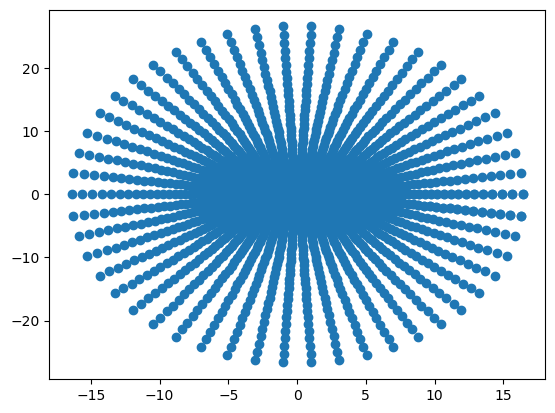

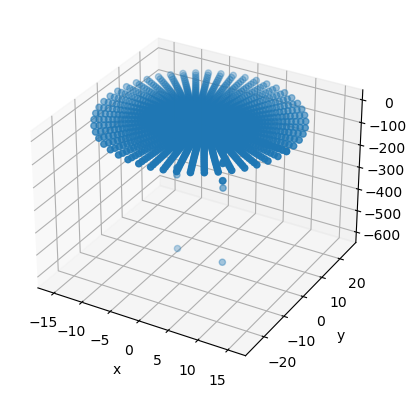

<Figure size 640x480 with 0 Axes>

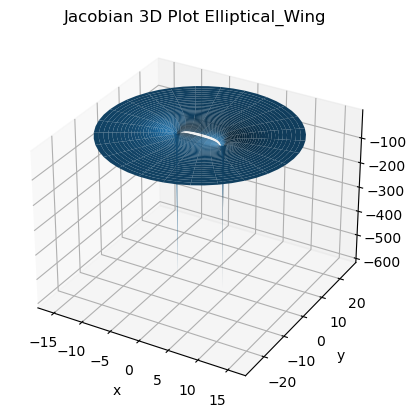

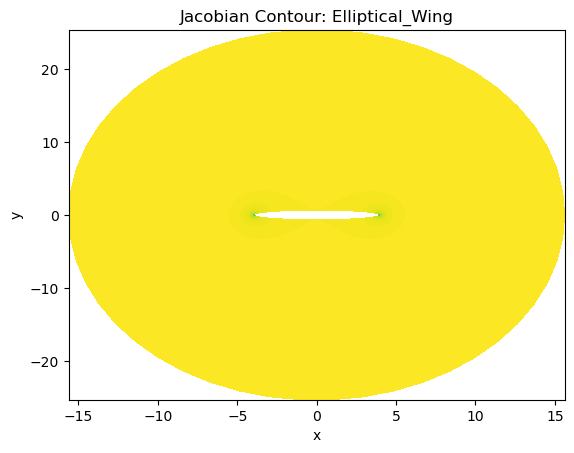

[[16.39249112 16.26323143 15.87749087 ... 16.26323143 16.39249112
  16.26323143]
 [15.6172483  15.49410164 15.12660373 ... 15.49410164 15.6172483
  15.49410164]
 [14.88105674 14.76371517 14.41354098 ... 14.76371517 14.88105674
  14.76371517]
 ...
 [ 4.          3.96845881  3.87433264 ...  3.96845881  4.
   3.96845881]
 [ 3.97521163  3.9438659   3.85032304 ...  3.9438659   3.97521163
   3.9438659 ]
 [ 3.96036335  3.9291347   3.83594126 ...  3.9291347   3.96036335
   3.9291347 ]]
[[-6.54257637e-15 -3.34791326e+00 -6.64302793e+00 ...  3.34791326e+00
   0.00000000e+00 -3.34791326e+00]
 [-6.21352667e-15 -3.17953466e+00 -6.30892617e+00 ...  3.17953466e+00
   0.00000000e+00 -3.17953466e+00]
 [-5.90001403e-15 -3.01910656e+00 -5.99060000e+00 ...  3.01910656e+00
   0.00000000e+00 -3.01910656e+00]
 ...
 [-2.44929360e-16 -1.25333234e-01 -2.48689887e-01 ...  1.25333234e-01
   0.00000000e+00 -1.25333234e-01]
 [-1.62946781e-16 -8.33817842e-02 -1.65448588e-01 ...  8.33817842e-02
   0.00000000e+00 -8.3

In [1799]:
def ellipticalgridgen(numxiint,numetaint,numghosts,plot=False): 
    divfactor = 20
    # numxint is the number of internal points in i. Number of intervals is numpts-1.
    # numyint is the number of internal points in j. Number of intervals is numpts-1.
    
    # This calculation is copied in main() rather than passing more info to the function
    # Probably a bad design decision, make these inputs to the function
    # total number of points in each direction
    Ni = numxiint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    Nj = numetaint + 2*numghosts # number internal points + number ghosts, acct for ghosts on 2 sides
    
    dxi = 1
    deta = 1
    
    xi = np.zeros((Nj,Ni))
    eta = np.zeros((Nj,Ni))
    for i in range(0,Ni,dxi): # from 0 to Ni with step size 1. 
        for j in range(0,Nj,deta): # from 0 to Nj with step size 1
            xi[j,i] = Ni-i-1
            eta[j,i] = Nj-j+1
    # The reason I use two for loops instead of np.arange 
    # is that I don't want to write a for loop to copy one vector many times, since xi and eta are the same.
    # This is inefficient storage-wise, but it works nicely to make all the data have the same 2D format.

    x = getellipticalx(xi-numghosts,(eta-numghosts)/divfactor,divfactor)
    y = getellipticaly(xi-numghosts,(eta-numghosts)/divfactor,divfactor)
    
    # print(xi/(np.amax(xi)-1))
    print(xi)
    print(eta)
    # print(x)
    # print(y)
    
    coords = np.zeros((Nj,Ni,9)) # Nj rows, Ni columns, 9 layers
    coords[:] = np.nan
    # coords[:] = 27
    # Note that any value that is not filled will default to zero. 
    # This can be dangerous, so I fill all the unused values with NaN's
    
    # coords[0:Nj,0:Ni,0] = x
    coords[:,:,0] = x 
    coords[:,:,1] = y
    coords[:,:,2] = xi
    coords[:,:,3] = eta
    # Note that this includes values of coordinates for the ghost cells
    
    coords = meshmetrics(numxiint,numetaint,numghosts,coords) #note that the slice indexing excludes the last value

    # coords contains an array for each of x, y, xi, and eta, and derivatives of xi and eta. 
    # Each specific value can be accessed by indices i,j.
    # For x, coords[j,i,0]=xval, coords[j,i,1] = yval, coords[j,i,2]=xival, coords[j,i,3]=etaval.
    # coords[j,i,4] = dxidx, coords[j,i,5] = detadx, coords[j,i,6] = dxidy, coords[j,i,7] = detady, coords[j,i,8] = J

    J = coords[:,:,8]
    
    # Plot grid
    if plot:
        plt.figure()
        plt.scatter(x,y)
        plt.show()
        PlotJacobian(x,y,J,levels=100,filename='Elliptical_Wing')
    
    return coords



def getellipticalx(xi,eta,divfactor):
    # point in the mesh that creates the 4:1 ellipse. 
    x = 4/math.cosh(3/divfactor)*np.cosh(eta)*np.cos(2*math.pi*xi/(np.amax(xi))) #(xi-numghosts)*dx # for this particular mesh, where x=xi (but then subtract the ghosts)
    return x

def getellipticaly(xi,eta,divfactor):
    y = np.sinh(eta)/math.sinh(3/divfactor)*np.sin(2*math.pi*xi/(np.amax(xi))) #(eta-numghosts)*dy # y=eta (but subtract the ghosts)
    return y



ellipticalgrid = ellipticalgridgen(numxiint=50,numetaint=40,numghosts=1,plot=True)
# Use 50, 10 for a nice plot to explain the info well
# Use 50, 27 for a nice grid with ~ 50 chord lengths in x and ~40 chord lengths in y


# sodshockgrid(j, i, quantity index)
x = ellipticalgrid[:,:,0]
print(x) # x
y = ellipticalgrid[:,:,1]
print(y) #y
# print(ellipticalgrid[:,:,2]/(np.amax(ellipticalgrid[:,:,2])-1)) #xi
# print(ellipticalgrid[:,:,3]) # eta
# print(ellipticalgrid[:,:,4]) # dxidx
# print(ellipticalgrid[:,:,5]) # detadx
# print(ellipticalgrid[:,:,6]) # dxidy
# print(ellipticalgrid[:,:,7]) # detady
J = ellipticalgrid[:,:,8]
# print(J) # J

# Elliptical Initialization

We want to initialize the whole domain to have u=Ufreestream and v=0, except the ghost cells at the outer edge, the ghost cells at the overlap line, and the ghost cells on the inner edge and one layer into the domain. 

In [1800]:
def EllipticalInitial(grid,numxint,numyint,numghosts,M): # where M is the mach number of the case we're interested in
    xvals = grid[:,:,0]
    yvals = grid[:,:,1]
    # 4 quantities per point (i,j)
    # 0 is rho
    # 1 is rho*u
    # 2 is rho*v
    # 3 is rho*E
    rE = p_infty/(gamma-1) + rho_infty*((M*c_infty)**2)/2
    # Note that p_infty = 1/gamma, rho_infty=1, c_infty = 1
    # Note that this does not account for any vertical velocity I would like to add.
    # If I want to add vertical velocity for some angle of attack,
    # I will have to add a term for n=rho*v**2 = rho*(c*M_vertical)**2
    
    Uinitial = np.zeros((numyint+2*numghosts,numxint+2*numghosts,4))
    Uinitial[:,:,:] = np.nan
    
    for i in range(1,numxint+1): # +1 because we want to exclude ghosts
        for j in range(1,numyint+1): # +1 because we want to exclude ghosts, but we still want to initialize the inner edge (then swap the velocities using BCs)
            Uinitial[j,i,:] = np.array([1, M, 0, rE]) 

    # plotU(xvals,yvals,Uinitial,index=0,levels=5,save=False,filename='Elliptical_Initial')
    # plotU(xvals,yvals,Uinitial,index=1,levels=5,save=False,filename='Elliptical_Initial')
    # plotU(xvals,yvals,Uinitial,index=2,levels=5,save=False,filename='Elliptical_Initial')
    # plotU(xvals,yvals,Uinitial,index=3,levels=5,save=False,filename='Elliptical_Initial')
    # plotU(xvals,yvals,Uinitial,index=4,levels=5,save=False,filename='Elliptical_Initial')
    
    return Uinitial

# Fill Boundary Conditions

- On the points one layer into the domain, which we say are at the "surface", we require zero velocity normal to the surface, and nominally neumann velocity tangential to the surface. However, we still allow energy and density to fluctuate.
- On the ghost cells inside the wing, we have neumann BCs in density, pressure, and tangential velocity. We have zero velocity normal to the surface. 
- For both sets of ghost cells at the overlap line, we use a periodic/cyclic boundary condition.
- For the ghost cells on the outside, we set a dirchlet free stream density, pressure, and velocity.

For all these ghost cells, in theory we only need to recompute the periodic and neumann boundary conditions at each time step, and as long as we don't overwrite the dirchlet boundary conditions in the ghost cells, we don't need to recompute it at each time step.

In [1801]:
def FillEllipseBCs(U,grid,numxiint,numetaint,M):
    # print(np.shape(U))
    # print(numxiint)
    # print(numetaint)
    # format of indexing is U[eta,xi,Uindex]
    xi = grid[1,1:,2] # get a single vector, since it's the same for all eta values
    # eta = grid[:,:,3]

    
    # At the surface of the wing, change the rhou and rhov to be neumann in utilde and 0 in vtilde?
    # This means the first 3 cells (ghost + surface + first off) will have the same utilde
    # rho and rhoE values should be computed at the surface, no requirements there
    # eta = 3
    
    # eta=2 for ghost cells, eta index of etamax
    # eta=3 for surface of wing, corresponding to eta index of etamax-1
    # eta=4 or one point above the surface of the wing, in the flow, eta index of etamax-2
    etamax = numetaint+1 # eta value for ghost cells in wing
    rE = p_infty/(gamma-1) + rho_infty*((M*c_infty)**2)/2 # for free-stream BC
    for xival in range(1,numxiint+1): # SHOULD EXCLUDE GHOST CELLS IN XI
        xival = int(xival)
        xi_x3 = grid[etamax-1,xival,4] 
        xi_y3 = grid[etamax-1,xival,6]
        eta_x3 = grid[etamax-1,xival,5]
        eta_y3 = grid[etamax-1,xival,7]
        xi_x4 = grid[etamax-2,xival,4] 
        xi_y4 = grid[etamax-2,xival,6]
        u4 = U[etamax-2,xival,1]/U[etamax-2,xival,0]
        v4 = U[etamax-2,xival,2]/U[etamax-2,xival,0]
        U[etamax-1,xival,1] = U[etamax-1,xival,0] * (xi_x4*u4+xi_y4*v4) / (xi_x3 - xi_y3*eta_x3/eta_y3) #u,eta=3
        U[etamax-1,xival,2] = U[etamax-1,xival,0] * (xi_x4*u4+xi_y4*v4) / (-xi_x3*eta_y3/eta_x3 + xi_y3)
        # U[etamax-1,xival,2] = - eta_x3/eta_y3*U[etamax-1,xival,1] #v,eta=3. rho is already included in the value, so we don't need it again
        # At the outer layer, eta = etamax, eta index of 0, should be dirchlet at infinity
        U[0,xival,:] = [rho_infty,rho_infty*M*c_infty,0,rE]
        
        # Checking that the requirement is satisfied
        # u3 = U[etamax-1,xival,1]/U[etamax-1,xival,0]
        # v3 = U[etamax-1,xival,2]/U[etamax-1,xival,0]
        # print('---------')
        # print('xi = ' + str(xival))
        # print('u3 = ' + str(u3))
        # print('v3 = ' + str(v3))
        # utilde = xi_x3*u3 + xi_y3*v3
        # vtilde = eta_x3*u3 + eta_y3*v3
        # print('utilde = ' + str(utilde))
        # print('vtilde = ' + str(vtilde))
        
    
    # At the first layer (ghost cells) should be entirely Neumann? Neumann density and energy, Neumann u and v
    # Because derivatives of xi and eta will be non-existent, we can't define utilde and vtilde here.
    # eta = 2, corresponding to eta index of etamax-1
    U[etamax,:,:] = U[etamax-1,:,:]
    
    
    # Periodic BCs should be identical to the values at the ends
    # xi = 0 gets values from xi = numxiint, xi = numxiint+1 gets values from xi=1
    U[:,0,:] = U[:,numxiint,:]
    U[:,numxiint+1,:] = U[:,1,:]
    return U

# Define Residual

To determine convergence, we define a residual:
$$res = \sqrt{\left(\sum_{i=2}^{N_x-1} \sum_{j=2}^{N_y-1} \left[u^{(k+1)}(i,j)-u^{(k)}(i,j)\right]^2\right)/\left((N_x-2)(N_y-2)\right)}$$

With a tolerance of $10^{-6}$.

In [1802]:
def res(uk1,u,numxiint,numetaint): 
    #uk1 and uk are 2D numpy arrays of the quantity u. 
    # Whatever quantity you pick for u, this gives you the residual of that quantity.
    sumval = 0
    for i in range(1,numxiint+1):
        for j in range(1,numetaint+1):
            sumval += (uk1[j,i]-u[j,i])**2
    res = sumval / (numxiint*numetaint)
    # print('sumval = ' + str(sumval))
    return res

# Perform time stepping with Residual

In [1846]:
# getR and getdt might have to be modified so they work with elliptical/periodic bcs?
# Not if I write the boundary conditions correctly...

def ellipticalmain(M=0.4):
    print('--------------------------')
    print('Mach number = ' + str(M))
    
    # Grid parameters
    numxiint = 100 #50 #52 total
    numetaint = 15 #10 #12 total
    numghosts = 1
    
    Ni = numxiint + 2*numghosts
    Nj = numetaint + 2*numghosts 
    # eta goes from 2 to Nj+1 instead of 0 to Nj-1 
    # This makes the FillEllipseBCs and expeuler implementation more difficult..
    

    # Determine runtime
    stoptime = 1
    t0 = 0
    t = t0
    tstep = 0
    CFL = 0.1
    
    
    # Create grid and compute mesh metrics
    # xvalues 0, yvalues 1, xi values 2, eta values 3, 
    # dxidx 4, detadx 5, dxidy 6, detady 7, J 8
    grid = ellipticalgridgen(numxiint,numetaint,numghosts)
    xvals = grid[:,:,0]
    yvals = grid[:,:,1]
    J = grid[:,:,8]
    
    # Initialize solution and derivatives
    U = EllipticalInitial(grid,numxiint,numetaint,numghosts,M)
    # print('Pre-BC u:')
    # print(U[:,:,1]/U[:,:,0])
    U = FillEllipseBCs(U,grid,numxiint,numetaint,M)
    # print('Post-BC u:')
    # print(U[:,:,1]/U[:,:,0])
    
    resval = 1000 # initialize res to some value larger than 10**-6
    
    # Iterate while residual is not converged
    while resval >= 10**-10:
        Uold = U
        # print('rho = ')
        # print(U[:,:,0])
        # print('v = ')
        # print(U[:,:,2]/U[:,:,0])
        # print('E = ')
        # print(U[:,:,3]/U[:,:,0]-1.86571429)
        R = getR(U,numghosts,grid,Ni,Nj)
        # print('R = ')
        # print(R[:,:,2])
        
        dt = getdt(U,grid,numxiint,numetaint,CFL)
        tstep += 1
        t += dt
        
        U = expeuler(U,dt,J,R,Ni,Nj,numghosts) # NEED TO FIX THIS SINCE ETA STARTS AT 2
        U = FillEllipseBCs(U,grid,numxiint,numetaint,M)
        
        resval = res(U[:,:,1]/U[:,:,0],Uold[:,:,1]/Uold[:,:,0],numxiint,numetaint) # residual of x-velocity "u"
        print('for timestep = ' + str (tstep) + ' at t = ' + str(t) + ', dt = ' + str(dt), ' resval = ' + str(resval))
        
        if tstep%5 == 0:
            plotU(xvals,yvals,U,index=3,levels=3,save=False,filename='Elliptical_Final')
    
    print('Completed after ' + str(tstep) + ' time steps')
    plotU(xvals,yvals,U,index=0,levels=5,save=False,filename='Elliptical_Final')
    plotU(xvals,yvals,U,index=1,levels=5,save=False,filename='Elliptical_Final')
    plotU(xvals,yvals,U,index=2,levels=5,save=False,filename='Elliptical_Final')
    plotU(xvals,yvals,U,index=3,levels=5,save=False,filename='Elliptical_Final')
    plotU(xvals,yvals,U,index=4,levels=5,save=False,filename='Elliptical_Final')
    return U

--------------------------
Mach number = 0.4
[[101. 100.  99. ...   2.   1.   0.]
 [101. 100.  99. ...   2.   1.   0.]
 [101. 100.  99. ...   2.   1.   0.]
 ...
 [101. 100.  99. ...   2.   1.   0.]
 [101. 100.  99. ...   2.   1.   0.]
 [101. 100.  99. ...   2.   1.   0.]]
[[18. 18. 18. ... 18. 18. 18.]
 [17. 17. 17. ... 17. 17. 17.]
 [16. 16. 16. ... 16. 16. 16.]
 ...
 [ 4.  4.  4. ...  4.  4.  4.]
 [ 3.  3.  3. ...  3.  3.  3.]
 [ 2.  2.  2. ...  2.  2.  2.]]
for timestep = 1 at t = 0.0019388773505618205, dt = 0.0019388773505618205  resval = 3.679923274562834e-07


/var/folders/gt/8pyjhhlx0vvghzgvrm_c8gh80000gn/T/ipykernel_37070/689404267.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  U[etamax-1,xival,2] = U[etamax-1,xival,0] * (xi_x4*u4+xi_y4*v4) / (-xi_x3*eta_y3/eta_x3 + xi_y3)
/var/folders/gt/8pyjhhlx0vvghzgvrm_c8gh80000gn/T/ipykernel_37070/689404267.py:30: RuntimeWarning: divide by zero encountered in double_scalars
  U[etamax-1,xival,1] = U[etamax-1,xival,0] * (xi_x4*u4+xi_y4*v4) / (xi_x3 - xi_y3*eta_x3/eta_y3) #u,eta=3


for timestep = 2 at t = 0.003870355296702861, dt = 0.00193147794614104  resval = 3.6963042155309155e-07
for timestep = 3 at t = 0.005793532760062774, dt = 0.0019231774633599126  resval = 3.7611270371956133e-07
for timestep = 4 at t = 0.007707400287957151, dt = 0.001913867527894377  resval = 3.8739572744627694e-07
for timestep = 5 at t = 0.009610830234753965, dt = 0.0019034299467968149  resval = 4.0355470984170486e-07


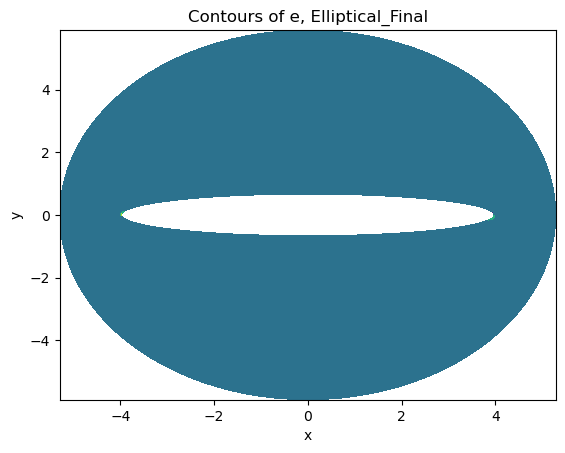

<Figure size 640x480 with 0 Axes>

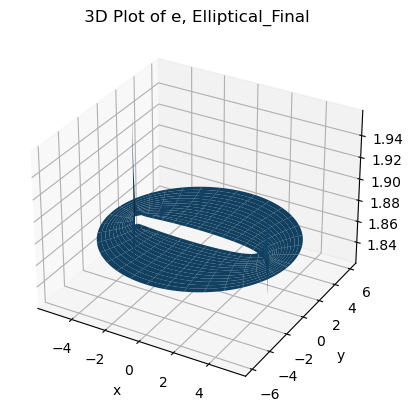

for timestep = 6 at t = 0.011502567469171245, dt = 0.0018917372344172804  resval = 4.247819526126054e-07
for timestep = 7 at t = 0.013381221343078202, dt = 0.0018786538739069562  resval = 4.5139316364047513e-07
for timestep = 8 at t = 0.015245259929722439, dt = 0.0018640385866442372  resval = 4.838432867096363e-07
for timestep = 9 at t = 0.017093007805197583, dt = 0.0018477478754751423  resval = 5.227546755586228e-07
for timestep = 10 at t = 0.018922648902389965, dt = 0.0018296410971923825  resval = 5.689620986318961e-07


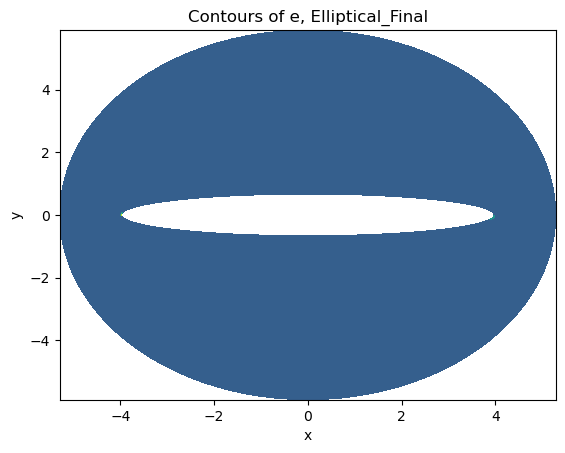

<Figure size 640x480 with 0 Axes>

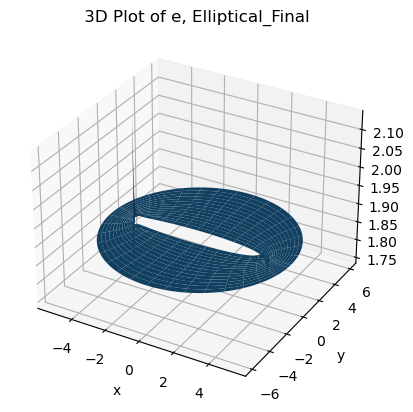

for timestep = 11 at t = 0.020732236166546153, dt = 0.0018095872641561883  resval = 6.235813660033391e-07
for timestep = 12 at t = 0.02251970981325405, dt = 0.0017874736467078968  resval = 6.881117396629846e-07
for timestep = 13 at t = 0.024282925842456036, dt = 0.0017632160292019876  resval = 7.645875340939201e-07
for timestep = 14 at t = 0.02601969600286611, dt = 0.0017367701604100731  resval = 8.558031370132127e-07
for timestep = 15 at t = 0.02772783956152538, dt = 0.0017081435586592695  resval = 9.656510046045963e-07


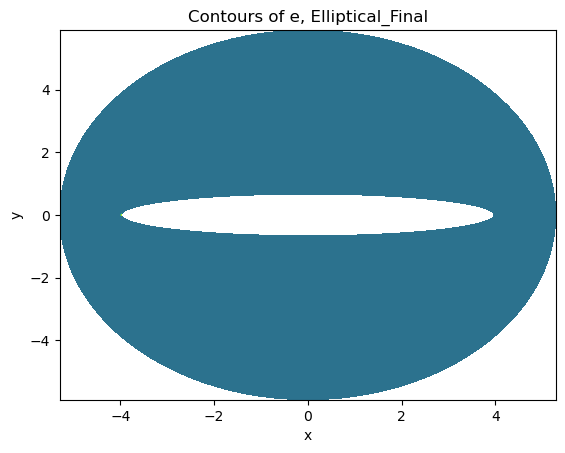

<Figure size 640x480 with 0 Axes>

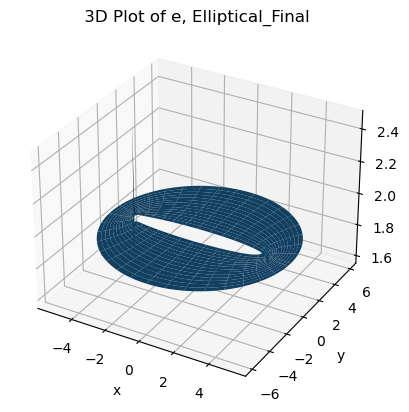

for timestep = 16 at t = 0.029405246008732865, dt = 0.0016774064472074848  resval = 1.0996328791576334e-06
for timestep = 17 at t = 0.031049946316964054, dt = 0.001644700308231191  resval = 1.2656107897862739e-06
for timestep = 18 at t = 0.032660188780464935, dt = 0.0016102424635008835  resval = 1.4748782714250506e-06
for timestep = 19 at t = 0.03423451401318101, dt = 0.0015743252327160796  resval = 1.7429215940825487e-06
for timestep = 20 at t = 0.03577181875131181, dt = 0.0015373047381307952  resval = 2.0257341024353662e-06


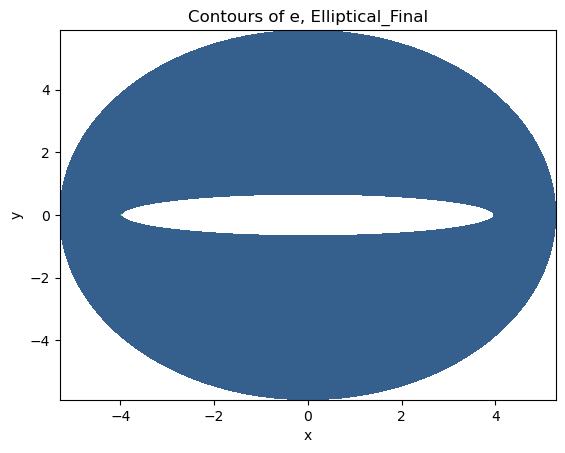

<Figure size 640x480 with 0 Axes>

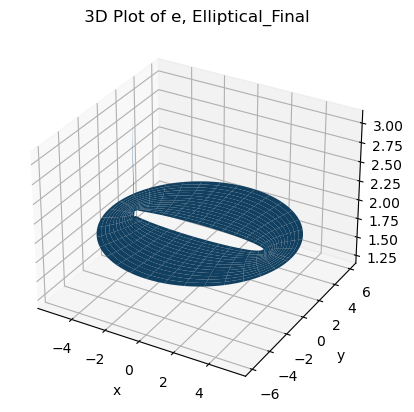

for timestep = 21 at t = 0.03727110971900877, dt = 0.0014992909676969637  resval = 2.3827761694037193e-06
for timestep = 22 at t = 0.03873172649553849, dt = 0.0014606167765297223  resval = 2.8680405597061406e-06
for timestep = 23 at t = 0.040153435934565426, dt = 0.001421709439026932  resval = 3.5503501025179174e-06
for timestep = 24 at t = 0.041536449393364955, dt = 0.0013830134587995285  resval = 4.543296188216181e-06


ValueError: math domain error

In [1847]:
Ufinal = ellipticalmain(M=0.4)

# Getting negative values of pressure and of rhoE... this is clearly incorrect. 
# Check that I define pressure correctly, using velocity, using Pramod's equation of state
# Check that my initialization with the values of rhoE are correct, even for the boundary conditions
# Check that my boundary condition in rhoE is correct (should be neumann in rhoE)
# the negative value occurs on the top of the ellipse, in the second layer (on the surface?)
# Check that my calculated values for rhoE are appropriate
# Could try simply rejecting negative rhoE, and whenever it is negative, making it zero...
# Top right quarter of the ellipse isn't updating values of rho... something's funky

# Code Graveyard (in case I need any of this stuff later)

In [ ]:

def get_dFdxi(U):
    # This takes in the 3D array U and returns a 3d array, the 1D vector dFdxi at all points in 2D mesh
    dFdxi = np.full_like(U,0)
    for i in np.shape(U)[0]: # NEED TO EXCLUDE THE GHOST CELLS
        for j in np.shape(U)[1]: # NEED TO EXCLUDE THE GHOST CELLS
            Fpl = fluxpm('F','plus',U[i,j],smoothing=True)
            Flopl = fluxpm('F','plus',U[i-1,j],smoothing=True)
            Fhimi = fluxpm('F','minus',U[i+1,j],smoothing=True)
            Fmi = fluxpm('F','minus',U[i,j],smoothing=True)
            # ADD IN COMPUTATION OF FTILDE, GTILDE
            dFdxi[i,j,:] = (Fpl - Flopl) + (Fhimi - Fmi)
            # NOTE THAT I ASSUME DELTA XI IS 1
    return dFdxi

def get_dGdeta(U):
    # This takes in the 3D array U and returns a 3d array, the 1D vector dGdxi at all points in 2D mesh
    dGdeta = np.full_like(U,0)
    for i in np.shape(U)[0]: # NEED TO EXCLUDE THE GHOST CELLS
        for j in np.shape(U)[1]: # NEED TO EXCLUDE THE GHOST CELLS
            Gpl = fluxpm('G','plus',U[i,j],smoothing=True)
            Glopl = fluxpm('G','plus',U[i-1,j],smoothing=True)
            Ghimi = fluxpm('G','minus',U[i+1,j],smoothing=True)
            Gmi = fluxpm('G','minus',U[i,j],smoothing=True)
            # ADD IN COMPUTATION OF FTILDE, GTILDE
            dGdeta[i,j,:] = (Gpl - Glopl) + (Ghimi - Gmi)
            # NOTE THAT I ASSUME DELTA ETA IS 1
    return dGdeta
